In [ ]:
#BUILT ON JUPYTER, LATER OPTIMIZED FOR VSCODE IPYNB TOO
#IF ON VSCODE, RUN WITH PYTHON 3.13 OR HIGHER
#DONT FORGET TO USE 'pip install streamlit' IN CMD

#FOR XAMPP, RUN APACHE AND MYSQL, Open phpmyadmin by clicking the MySQL admin, create a new database
#  IN SQL - CREATE DATABASE warehouse

#THEN RUN THE CODE


In [22]:
pip install mysql-connector-python pandas sqlalchemy ipython-sql matplotlib seaborn cursor


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\Administrator\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [23]:
pip install mysql-connector-python pandas sqlalchemy ipython-sql faker

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\Administrator\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [24]:
import mysql.connector

conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="",  # Add if you set a password
    database="warehouse"
)
cursor = conn.cursor()

In [25]:
import mysql.connector
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from IPython.display import display

# Establish connection
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="",
    database="warehouse"
)

# Create SQLAlchemy engine for pandas
engine = create_engine('mysql+mysqlconnector://root:@localhost/warehouse')

In [26]:


# 2. Import libraries
import mysql.connector
from mysql.connector import Error
import pandas as pd
from sqlalchemy import create_engine
from faker import Faker
import random
import string
from datetime import datetime, timedelta

# 3. Database connection class (properly manages connections)
class WarehouseDB:
    def __init__(self):
        self.conn = None
        self.cursor = None
        self.engine = None
    
    def connect(self):
        try:
            self.conn = mysql.connector.connect(
                host="localhost",
                user="root",
                password="",
                database="warehouse"
            )
            self.cursor = self.conn.cursor()
            self.engine = create_engine('mysql+mysqlconnector://root:@localhost/warehouse')
            print("Successfully connected to database")
        except Error as e:
            print(f"Error connecting to MySQL: {e}")
            raise
    
    def close(self):
        if self.cursor:
            self.cursor.close()
        if self.conn:
            self.conn.close()
        print("Database connection closed")
    
    def execute(self, query, params=None):
        try:
            self.cursor.execute(query, params or ())
            self.conn.commit()
            return True
        except Error as e:
            print(f"Error executing query: {e}")
            self.conn.rollback()
            return False
    
    def executemany(self, query, data):
        try:
            self.cursor.executemany(query, data)
            self.conn.commit()
            return True
        except Error as e:
            print(f"Error executing query: {e}")
            self.conn.rollback()
            return False

# 4. Initialize database connection
db = WarehouseDB()
db.connect()

# 5. Create tables function
def create_tables():
    queries = [
        """
        CREATE TABLE IF NOT EXISTS material (
            id VARCHAR(25) PRIMARY KEY,
            name VARCHAR(100),
            description TEXT,
            category VARCHAR(50),
            unit VARCHAR(20),
            current_quantity DECIMAL(10,2),
            min_quantity DECIMAL(10,2),
            max_quantity DECIMAL(10,2),
            location VARCHAR(50)
        )
        """,
        """
        CREATE TABLE IF NOT EXISTS department (
            id VARCHAR(25) PRIMARY KEY,
            name VARCHAR(100),
            manager VARCHAR(100),
            contact VARCHAR(50)
        )
        """,
        """
        CREATE TABLE IF NOT EXISTS user (
            user_id VARCHAR(25) PRIMARY KEY,
            username VARCHAR(50),
            password VARCHAR(100),
            name VARCHAR(100),
            role VARCHAR(50),
            department_id VARCHAR(25),
            FOREIGN KEY (department_id) REFERENCES department(id)
        )
        """,
        """
        CREATE TABLE IF NOT EXISTS purchase_order (
            po_number VARCHAR(25) PRIMARY KEY,
            material_id VARCHAR(25),
            quantity DECIMAL(10,2),
            order_date DATE,
            expected_delivery DATE,
            status VARCHAR(20),
            department_id VARCHAR(25),
            FOREIGN KEY (material_id) REFERENCES material(id),
            FOREIGN KEY (department_id) REFERENCES department(id)
        )
        """,
        """
        CREATE TABLE IF NOT EXISTS inventory_transaction (
            transaction_id VARCHAR(25) PRIMARY KEY,
            material_id VARCHAR(25),
            transaction_type ENUM('IN', 'OUT', 'TRANSFER', 'SCRAP'),
            quantity DECIMAL(10,2),
            transaction_date DATETIME,
            reference_number VARCHAR(25),
            user_id VARCHAR(25),
            notes TEXT,
            FOREIGN KEY (material_id) REFERENCES material(id)
        )
        """,
        """
        CREATE TABLE IF NOT EXISTS system_log (
            log_id INT AUTO_INCREMENT PRIMARY KEY,
            user_id VARCHAR(25),
            action VARCHAR(100),
            action_time DATETIME,
            ip_address VARCHAR(20),
            details TEXT,
            FOREIGN KEY (user_id) REFERENCES user(user_id)
        )
        """
    ]
    
    for query in queries:
        if not db.execute(query):
            return False
    return True

# 6. Generate dummy data
def generate_dummy_data():
    fake = Faker()
    
    # Helper functions
    def random_string(length=8):
        return ''.join(random.choices(string.ascii_uppercase + string.digits, k=length))
    
    def random_date(start_date, end_date):
        time_between = end_date - start_date
        random_days = random.randrange(time_between.days)
        return start_date + timedelta(days=random_days)
    
    # Generate Materials (50 items)
    categories = ['Electronics', 'Mechanical', 'Construction', 'Packaging', 'Raw Materials']
    units = ['pieces', 'kg', 'liters', 'boxes', 'units']
    
    materials = []
    for i in range(1, 51):
        materials.append((
            f"WZ2023{str(i).zfill(4)}",
            f"{fake.word().capitalize()} {random.choice(['Component', 'Part', 'Material'])}",
            fake.sentence(),
            random.choice(categories),
            random.choice(units),
            round(random.uniform(10, 1000), 2),
            round(random.uniform(5, 100), 2),
            round(random.uniform(200, 2000), 2),
            f"{random.choice(['A','B','C','D'])}{random.randint(1, 20)}"
        ))
    
    # Generate Departments (6 departments)
    departments = [
        ('DEPT001', 'Production', fake.name(), fake.phone_number()),
        ('DEPT002', 'Logistics', fake.name(), fake.phone_number()),
        ('DEPT003', 'Quality Control', fake.name(), fake.phone_number()),
        ('DEPT004', 'Maintenance', fake.name(), fake.phone_number()),
        ('DEPT005', 'Purchasing', fake.name(), fake.phone_number()),
        ('DEPT006', 'Warehouse', fake.name(), fake.phone_number())
    ]
    
    # Generate Users (15 users)
    roles = ['Manager', 'Supervisor', 'Operator', 'Clerk', 'Technician']
    users = []
    for i in range(1, 16):
        users.append((
            f"USER{str(i).zfill(4)}",
            fake.user_name(),
            random_string(12),
            fake.name(),
            random.choice(roles),
            random.choice(departments)[0]
        ))
    
    # Generate Purchase Orders (100 orders)
    statuses = ['Draft', 'Submitted', 'Approved', 'Received', 'Cancelled']
    purchase_orders = []
    start_date = datetime(2023, 1, 1)
    end_date = datetime(2023, 12, 31)
    
    for i in range(1, 101):
        order_date = random_date(start_date, end_date)
        expected_delivery = order_date + timedelta(days=random.randint(1, 14))
        purchase_orders.append((
            f"PO{order_date.strftime('%Y%m%d')}{str(i).zfill(4)}",
            random.choice(materials)[0],
            round(random.uniform(1, 100), 2),
            order_date,
            expected_delivery,
            random.choice(statuses),
            random.choice(departments)[0]
        ))
    
    # Generate Inventory Transactions (500 transactions)
    inventory_transactions = []
    po_numbers = [po[0] for po in purchase_orders]
    user_ids = [user[0] for user in users]
    
    for i in range(1, 501):
        trans_date = random_date(start_date, end_date)
        trans_type = random.choice(['IN', 'OUT', 'TRANSFER', 'SCRAP'])
        quantity = round(random.uniform(1, 50), 2)
        if trans_type in ['OUT', 'SCRAP']:
            quantity = -quantity
        
        inventory_transactions.append((
            f"TR{trans_date.strftime('%Y%m%d')}{str(i).zfill(5)}",
            random.choice(materials)[0],
            trans_type,
            quantity,
            trans_date,
            random.choice(po_numbers) if trans_type == 'IN' else None,
            random.choice(user_ids),
            fake.sentence() if random.random() > 0.7 else None
        ))
    
    # Generate System Logs (200 logs)
    system_logs = []
    actions = ['Login', 'Logout', 'Create PO', 'Approve PO', 'Receive Material', 'Issue Material']
    
    for i in range(1, 201):
        system_logs.append((
            random.choice(user_ids),
            random.choice(actions),
            random_date(start_date, end_date),
            fake.ipv4(),
            fake.sentence()
        ))
    
    return {
        'materials': materials,
        'departments': departments,
        'users': users,
        'purchase_orders': purchase_orders,
        'inventory_transactions': inventory_transactions,
        'system_logs': system_logs
    }

# 7. Load data to database
def load_data(data):
    # Insert materials
    db.executemany("""
    INSERT INTO material (id, name, description, category, unit, current_quantity, min_quantity, max_quantity, location)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
    """, data['materials'])
    
    # Insert departments
    db.executemany("""
    INSERT INTO department (id, name, manager, contact)
    VALUES (%s, %s, %s, %s)
    """, data['departments'])
    
    # Insert users
    db.executemany("""
    INSERT INTO user (user_id, username, password, name, role, department_id)
    VALUES (%s, %s, %s, %s, %s, %s)
    """, data['users'])
    
    # Insert purchase orders
    db.executemany("""
    INSERT INTO purchase_order (po_number, material_id, quantity, order_date, expected_delivery, status, department_id)
    VALUES (%s, %s, %s, %s, %s, %s, %s)
    """, data['purchase_orders'])
    
    # Insert inventory transactions
    db.executemany("""
    INSERT INTO inventory_transaction (transaction_id, material_id, transaction_type, quantity, transaction_date, reference_number, user_id, notes)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
    """, data['inventory_transactions'])
    
    # Insert system logs (skip log_id as it's auto-increment)
    db.executemany("""
    INSERT INTO system_log (user_id, action, action_time, ip_address, details)
    VALUES (%s, %s, %s, %s, %s)
    """, data['system_logs'])

# 8. Main execution
print("Creating tables...")
if create_tables():
    print("Tables created successfully")
    
    print("\nGenerating dummy data...")
    dummy_data = generate_dummy_data()
    
    print("\nLoading data to database...")
    load_data(dummy_data)
    
    print("\nData loaded successfully. Verifying counts:")
    
    # Verify counts
    tables = ['material', 'department', 'user', 'purchase_order', 'inventory_transaction', 'system_log']
    for table in tables:
        db.execute(f"SELECT COUNT(*) FROM {table}")
        count = db.cursor.fetchone()[0]
        print(f"{table}: {count} records")
else:
    print("Error creating tables")

# 9. Close connection
db.close()

Successfully connected to database
Creating tables...
Tables created successfully

Generating dummy data...

Loading data to database...

Data loaded successfully. Verifying counts:
Error executing query: Unread result found


TypeError: 'NoneType' object is not subscriptable

In [27]:
# Reconnect to database
db = WarehouseDB()
db.connect()

# 1. Get sample materials
materials = db.execute("SELECT * FROM material LIMIT 5", fetch=True)
print("Sample materials:")
for row in materials:
    print(row)

# 2. Get transaction summary
transactions = db.execute("""
SELECT transaction_type, COUNT(*) as count, SUM(quantity) as total_quantity
FROM inventory_transaction
GROUP BY transaction_type
""", fetch=True)
print("\nTransaction summary:")
for row in transactions:
    print(row)

# 3. Get department-wise usage
usage = db.execute("""
SELECT d.name, COUNT(it.transaction_id) as transaction_count
FROM inventory_transaction it
JOIN purchase_order po ON it.reference_number = po.po_number
JOIN department d ON po.department_id = d.id
GROUP BY d.name
ORDER BY transaction_count DESC
""", fetch=True)
print("\nDepartment usage:")
for row in usage:
    print(row)

db.close()

Successfully connected to database


TypeError: WarehouseDB.execute() got an unexpected keyword argument 'fetch'

In [28]:
def create_data_warehouse_schema():
    dw_queries = [
        """CREATE TABLE IF NOT EXISTS dim_date (
            date_id DATE PRIMARY KEY,
            day INT,
            month INT,
            quarter INT,
            year INT,
            day_of_week INT,
            day_name VARCHAR(10),
            month_name VARCHAR(10),
            is_weekend BOOLEAN
        )""",
        """CREATE TABLE IF NOT EXISTS dim_material (
            material_id VARCHAR(25) PRIMARY KEY,
            material_name VARCHAR(100),
            category VARCHAR(50),
            unit VARCHAR(20),
            current_quantity DECIMAL(10,2),
            min_quantity DECIMAL(10,2),
            max_quantity DECIMAL(10,2)
        )""",
        """CREATE TABLE IF NOT EXISTS dim_department (
            department_id VARCHAR(25) PRIMARY KEY,
            department_name VARCHAR(100),
            manager VARCHAR(100)
        )""",
        """CREATE TABLE IF NOT EXISTS dim_transaction_type (
            transaction_type_id INT AUTO_INCREMENT PRIMARY KEY,
            transaction_type VARCHAR(20),
            transaction_category VARCHAR(20)
        )""",
        """CREATE TABLE IF NOT EXISTS fact_inventory (
            transaction_id VARCHAR(25) PRIMARY KEY,
            date_id DATE,
            material_id VARCHAR(25),
            department_id VARCHAR(25),
            transaction_type_id INT,
            quantity DECIMAL(10,2),
            remaining_quantity DECIMAL(10,2),
            FOREIGN KEY (date_id) REFERENCES dim_date(date_id),
            FOREIGN KEY (material_id) REFERENCES dim_material(material_id),
            FOREIGN KEY (department_id) REFERENCES dim_department(department_id),
            FOREIGN KEY (transaction_type_id) REFERENCES dim_transaction_type(transaction_type_id)
        )""",
        """CREATE TABLE IF NOT EXISTS fact_inventory_snapshot (
            snapshot_id INT AUTO_INCREMENT PRIMARY KEY,
            date_id DATE,
            material_id VARCHAR(25),
            quantity DECIMAL(10,2),
            FOREIGN KEY (date_id) REFERENCES dim_date(date_id),
            FOREIGN KEY (material_id) REFERENCES dim_material(material_id)
        )"""
    ]
    
    db = WarehouseDB()
    db.connect()
    
    for query in dw_queries:
        if not db.execute(query):
            print(f"Failed to execute: {query}")
            db.close()
            return False
    
    db.close()
    return True

# Execute the function
if create_data_warehouse_schema():
    print("Data warehouse schema created successfully!")
else:
    print("Failed to create data warehouse schema")

Successfully connected to database
Database connection closed
Data warehouse schema created successfully!


In [29]:
def populate_data_warehouse():
    db = WarehouseDB()
    db.connect()
    
    try:
        # 1. Populate date dimension
        date_range = pd.date_range(start='2023-01-01', end='2023-12-31')
        dim_date = pd.DataFrame({
            'date_id': date_range,
            'day': date_range.day,
            'month': date_range.month,
            'quarter': date_range.quarter,
            'year': date_range.year,
            'day_of_week': date_range.dayofweek + 1,
            'day_name': date_range.day_name(),
            'month_name': date_range.month_name(),
            'is_weekend': date_range.dayofweek.isin([5, 6])
        })
        dim_date.to_sql('dim_date', db.engine, if_exists='append', index=False)
        
        # 2. Populate transaction type dimension
        transaction_types = [
            ('IN', 'Inbound'),
            ('OUT', 'Outbound'),
            ('TRANSFER', 'Internal'),
            ('SCRAP', 'Outbound')
        ]
        pd.DataFrame(transaction_types, 
                    columns=['transaction_type', 'transaction_category'])\
          .to_sql('dim_transaction_type', db.engine, if_exists='append', index=False)
        
        # 3. Extract and transform operational data
        # Material dimension
        pd.read_sql("""
        SELECT 
            id as material_id, 
            name as material_name, 
            category, 
            unit, 
            current_quantity, 
            min_quantity, 
            max_quantity 
        FROM material
        """, db.engine).to_sql('dim_material', db.engine, if_exists='append', index=False)
        
        # Department dimension
        pd.read_sql("""
        SELECT 
            id as department_id, 
            name as department_name, 
            manager 
        FROM department
        """, db.engine).to_sql('dim_department', db.engine, if_exists='append', index=False)
        
        # 4. Load fact tables
        # Inventory transactions fact
        pd.read_sql("""
        SELECT 
            it.transaction_id,
            DATE(it.transaction_date) as date_id,
            it.material_id,
            po.department_id,
            CASE it.transaction_type
                WHEN 'IN' THEN 1
                WHEN 'OUT' THEN 2
                WHEN 'TRANSFER' THEN 3
                WHEN 'SCRAP' THEN 4
            END as transaction_type_id,
            it.quantity,
            m.current_quantity as remaining_quantity
        FROM inventory_transaction it
        JOIN material m ON it.material_id = m.id
        LEFT JOIN purchase_order po ON it.reference_number = po.po_number
        """, db.engine).to_sql('fact_inventory', db.engine, if_exists='append', index=False)
        
        # Inventory snapshots fact
        pd.read_sql("""
        WITH daily_inventory AS (
            SELECT 
                DATE(transaction_date) as snapshot_date,
                material_id,
                SUM(CASE WHEN transaction_type = 'IN' THEN quantity ELSE 0 END) -
                SUM(CASE WHEN transaction_type IN ('OUT', 'SCRAP') THEN quantity ELSE 0 END) as net_quantity
            FROM inventory_transaction
            GROUP BY DATE(transaction_date), material_id
        )
        SELECT 
            snapshot_date as date_id,
            material_id,
            SUM(net_quantity) OVER (PARTITION BY material_id ORDER BY snapshot_date) as quantity
        FROM daily_inventory
        ORDER BY material_id, snapshot_date
        """, db.engine).to_sql('fact_inventory_snapshot', db.engine, if_exists='append', index=False)
        
        print("Data warehouse populated successfully!")
        return True
        
    except Exception as e:
        print(f"Error during ETL: {e}")
        return False
    finally:
        db.close()

# Execute ETL process
if populate_data_warehouse():
    print("Ready for analysis!")
else:
    print("ETL process failed")

Successfully connected to database
Data warehouse populated successfully!
Database connection closed
Ready for analysis!


In [30]:
def execute_rolap_analysis():
    db = WarehouseDB()
    db.connect()
    
    try:
        # 1. Inventory Movement Cube (Time × Category × Department)
        inventory_movement = pd.read_sql("""
        SELECT 
            d.year,
            d.quarter,
            d.month_name,
            m.category,
            dept.department_name,
            SUM(f.quantity) as total_quantity,
            COUNT(f.transaction_id) as transaction_count
        FROM fact_inventory f
        JOIN dim_date d ON f.date_id = d.date_id
        JOIN dim_material m ON f.material_id = m.material_id
        JOIN dim_department dept ON f.department_id = dept.department_id
        GROUP BY 
            d.year,
            d.quarter,
            d.month_name,
            m.category,
            dept.department_name
        WITH ROLLUP
        """, db.engine)
        
        # 2. Inventory Status Analysis
        inventory_status = pd.read_sql("""
        SELECT 
            m.material_name,
            m.category,
            AVG(s.quantity) as avg_quantity,
            m.min_quantity,
            m.max_quantity,
            CASE 
                WHEN AVG(s.quantity) < m.min_quantity THEN 'Below Minimum'
                WHEN AVG(s.quantity) > m.max_quantity THEN 'Above Maximum'
                ELSE 'Within Range'
            END as status
        FROM fact_inventory_snapshot s
        JOIN dim_material m ON s.material_id = m.material_id
        GROUP BY m.material_name, m.category, m.min_quantity, m.max_quantity
        ORDER BY status, m.category
        """, db.engine)
        
        # 3. Department Consumption Patterns
        dept_consumption = pd.read_sql("""
        SELECT 
            dept.department_name,
            m.category,
            SUM(CASE WHEN f.quantity < 0 THEN ABS(f.quantity) ELSE 0 END) as consumed_quantity,
            ROUND(SUM(CASE WHEN f.quantity < 0 THEN ABS(f.quantity) ELSE 0 END) * 100.0 / 
                (SELECT SUM(ABS(quantity)) FROM fact_inventory WHERE quantity < 0), 2) as percentage_of_total
        FROM fact_inventory f
        JOIN dim_department dept ON f.department_id = dept.department_id
        JOIN dim_material m ON f.material_id = m.material_id
        JOIN dim_transaction_type t ON f.transaction_type_id = t.transaction_type_id
        WHERE t.transaction_category = 'Outbound'
        GROUP BY dept.department_name, m.category
        ORDER BY dept.department_name, consumed_quantity DESC
        """, db.engine)
        
        return {
            'inventory_movement': inventory_movement,
            'inventory_status': inventory_status,
            'dept_consumption': dept_consumption
        }
        
    finally:
        db.close()

# Execute and display results
results = execute_rolap_analysis()
print("Inventory Movement Cube:")
display(results['inventory_movement'].head(10))

print("\nInventory Status Analysis:")
display(results['inventory_status'].head(10))

print("\nDepartment Consumption Patterns:")
display(results['dept_consumption'].head(10))

Successfully connected to database
Database connection closed
Inventory Movement Cube:


,year,quarter,month_name,category,department_name,total_quantity,transaction_count
0,2023.0,1.0,February,Construction,Production,37.60,1
1,2023.0,1.0,February,Construction,Quality Control,47.58,1
2,2023.0,1.0,February,Construction,None,85.18,2
3,2023.0,1.0,February,Electronics,Purchasing,48.03,1
4,2023.0,1.0,February,Electronics,None,48.03,1
5,2023.0,1.0,February,Mechanical,Purchasing,47.57,1
6,2023.0,1.0,February,Mechanical,Quality Control,11.80,1
7,2023.0,1.0,February,Mechanical,None,59.37,2
8,2023.0,1.0,February,Packaging,Maintenance,30.90,1
9,2023.0,1.0,February,Packaging,Purchasing,25.16,1



Inventory Status Analysis:


,material_name,category,avg_quantity,min_quantity,max_quantity,status
0,Summer Component,Construction,60.945000,84.06,1402.10,Below Minimum
1,Staff Material,Construction,67.656000,97.17,1056.15,Below Minimum
2,Edge Part,Construction,67.125000,82.76,1490.13,Below Minimum
3,Never Part,Construction,39.726000,40.48,1174.57,Below Minimum
4,Voice Component,Construction,23.310000,79.39,1381.93,Below Minimum
5,If Component,Electronics,33.016000,69.39,1086.37,Below Minimum
6,Land Part,Electronics,60.742857,96.41,1837.28,Below Minimum
7,There Material,Mechanical,77.326000,80.31,1012.13,Below Minimum
8,First Part,Packaging,54.201667,72.93,311.65,Below Minimum
9,Hospital Component,Packaging,48.196667,53.13,859.56,Below Minimum



Department Consumption Patterns:


,department_name,category,consumed_quantity,percentage_of_total


In [31]:
def create_and_analyze_cuboids():
    db = WarehouseDB()
    db.connect()
    
    try:
        # Get base cuboid with all dimensions
        full_cuboid = pd.read_sql("""
        SELECT 
            d.year,
            d.quarter,
            d.month_name,
            dept.department_name,
            m.category,
            t.transaction_type,
            SUM(f.quantity) as total_quantity,
            COUNT(f.transaction_id) as transaction_count
        FROM fact_inventory f
        JOIN dim_date d ON f.date_id = d.date_id
        JOIN dim_department dept ON f.department_id = dept.department_id
        JOIN dim_material m ON f.material_id = m.material_id
        JOIN dim_transaction_type t ON f.transaction_type_id = t.transaction_type_id
        GROUP BY 
            d.year,
            d.quarter,
            d.month_name,
            dept.department_name,
            m.category,
            t.transaction_type
        """, db.engine)
        
        # Create specific cuboids
        # 1. Time × Category cuboid
        time_category_cuboid = pd.pivot_table(
            full_cuboid,
            values='total_quantity',
            index=['year', 'quarter', 'month_name'],
            columns=['category'],
            aggfunc=np.sum,
            fill_value=0
        )
        
        # 2. Department × Transaction Type cuboid
        dept_transaction_cuboid = pd.pivot_table(
            full_cuboid,
            values='total_quantity',
            index=['department_name'],
            columns=['transaction_type'],
            aggfunc=np.sum,
            fill_value=0
        )
        
        # 3. Material × Time cuboid
        material_time_cuboid = pd.read_sql("""
        SELECT 
            m.material_name,
            d.year,
            d.quarter,
            SUM(f.quantity) as total_quantity
        FROM fact_inventory f
        JOIN dim_date d ON f.date_id = d.date_id
        JOIN dim_material m ON f.material_id = m.material_id
        GROUP BY m.material_name, d.year, d.quarter
        ORDER BY m.material_name, d.year, d.quarter
        """, db.engine).pivot(
            index='material_name',
            columns=['year', 'quarter'],
            values='total_quantity'
        ).fillna(0)
        
        return {
            'full_cuboid': full_cuboid,
            'time_category': time_category_cuboid,
            'dept_transaction': dept_transaction_cuboid,
            'material_time': material_time_cuboid
        }
        
    finally:
        db.close()

# Execute and display cuboids
cuboids = create_and_analyze_cuboids()
print("Full Cuboid Sample:")
display(cuboids['full_cuboid'].head(10))

print("\nTime × Category Cuboid:")
display(cuboids['time_category'].head())

print("\nDepartment × Transaction Type Cuboid:")
display(cuboids['dept_transaction'])

print("\nMaterial × Time Cuboid:")
display(cuboids['material_time'].head())

Successfully connected to database
Database connection closed
Full Cuboid Sample:


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15172\634013850.py:33: FutureWarning: The provided callable <function sum at 0x0000029C5CE74A40> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  time_category_cuboid = pd.pivot_table(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15172\634013850.py:43: FutureWarning: The provided callable <function sum at 0x0000029C5CE74A40> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dept_transaction_cuboid = pd.pivot_table(


,year,quarter,month_name,department_name,category,transaction_type,total_quantity,transaction_count
0,2023,1,February,Maintenance,Packaging,IN,30.90,1
1,2023,1,February,Production,Construction,IN,37.60,1
2,2023,1,February,Purchasing,Electronics,IN,48.03,1
3,2023,1,February,Purchasing,Mechanical,IN,47.57,1
4,2023,1,February,Purchasing,Packaging,IN,25.16,1
5,2023,1,February,Quality Control,Construction,IN,47.58,1
6,2023,1,February,Quality Control,Mechanical,IN,11.80,1
7,2023,1,January,Logistics,Mechanical,IN,28.19,1
8,2023,1,January,Logistics,Packaging,IN,48.77,2
9,2023,1,January,Maintenance,Raw Materials,IN,35.17,1



Time × Category Cuboid:


category                 Construction  Electronics  Mechanical  Packaging  \
year quarter month_name                                                     
2023 1       February           85.18        48.03       59.37      56.06   
             January           117.08        37.38       28.19      48.77   
             March             121.12        57.82        0.00      61.14   
     2       April              84.71        14.86       59.68     127.69   
             June               35.21        60.38       99.86      53.60   

category                 Raw Materials  
year quarter month_name                 
2023 1       February             0.00  
             January             35.17  
             March               40.75  
     2       April               26.35  
             June                 0.00


Department × Transaction Type Cuboid:


transaction_type,IN
department_name,
Logistics,732.53
Maintenance,494.13
Production,684.03
Purchasing,423.26
Quality Control,547.01
Warehouse,289.13



Material × Time Cuboid:


year               2023                     
quarter               1      2      3      4
material_name                               
Alone Component   -4.78  12.94  44.66  -1.69
And Component     -1.45 -57.82  -8.09 -18.24
Better Component  40.16 -39.26  33.37  26.18
Campaign Part     82.00  -9.08  37.08  41.94
Care Part         26.22 -36.81 -74.22  36.43

In [32]:
def perform_data_mining():
    db = WarehouseDB()
    db.connect()
    
    try:
        # 1. Inventory Trend Analysis with Moving Averages
        inventory_trend = pd.read_sql("""
        SELECT 
            d.date_id,
            m.material_name,
            s.quantity,
            LAG(s.quantity, 1) OVER (PARTITION BY m.material_name ORDER BY d.date_id) as prev_quantity,
            s.quantity - LAG(s.quantity, 1) OVER (PARTITION BY m.material_name ORDER BY d.date_id) as quantity_change
        FROM fact_inventory_snapshot s
        JOIN dim_date d ON s.date_id = d.date_id
        JOIN dim_material m ON s.material_id = m.material_id
        WHERE m.category = 'Electronics'
        ORDER BY m.material_name, d.date_id
        """, db.engine)
        
        # Calculate moving averages
        inventory_trend['7_day_ma'] = inventory_trend.groupby('material_name')['quantity']\
            .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
        
        # 2. ABC Inventory Analysis
        abc_analysis = pd.read_sql("""
        WITH inventory_value AS (
            SELECT 
                m.material_name,
                m.category,
                AVG(s.quantity) as avg_quantity,
                -- Assuming unit_cost exists or using a placeholder
                50 as unit_cost,  -- Placeholder - replace with actual cost if available
                AVG(s.quantity) * 50 as inventory_value
            FROM fact_inventory_snapshot s
            JOIN dim_material m ON s.material_id = m.material_id
            GROUP BY m.material_name, m.category
        ),
        cumulative AS (
            SELECT 
                *,
                SUM(inventory_value) OVER (ORDER BY inventory_value DESC) as running_total,
                SUM(inventory_value) OVER () as grand_total,
                100.0 * SUM(inventory_value) OVER (ORDER BY inventory_value DESC) / 
                    SUM(inventory_value) OVER () as cumulative_percentage
            FROM inventory_value
        )
        SELECT 
            material_name,
            category,
            avg_quantity,
            inventory_value,
            cumulative_percentage,
            CASE 
                WHEN cumulative_percentage <= 80 THEN 'A'
                WHEN cumulative_percentage <= 95 THEN 'B'
                ELSE 'C'
            END as abc_class
        FROM cumulative
        ORDER BY inventory_value DESC
        """, db.engine)
        
        # 3. Association Rule Mining (Frequent Itemsets)
        frequent_itemsets = pd.read_sql("""
        WITH po_materials AS (
            SELECT 
                po.po_number,
                GROUP_CONCAT(m.category ORDER BY m.category) as material_categories
            FROM purchase_order po
            JOIN material m ON po.material_id = m.id
            GROUP BY po.po_number
            HAVING COUNT(DISTINCT m.category) > 1
        )
        SELECT 
            material_categories,
            COUNT(*) as frequency
        FROM po_materials
        GROUP BY material_categories
        ORDER BY frequency DESC
        LIMIT 10
        """, db.engine)
        
        return {
            'inventory_trend': inventory_trend,
            'abc_analysis': abc_analysis,
            'frequent_itemsets': frequent_itemsets
        }
        
    finally:
        db.close()

# Execute data mining
mining_results = perform_data_mining()
print("Inventory Trend Analysis:")
display(mining_results['inventory_trend'].head(10))

print("\nABC Inventory Analysis:")
display(mining_results['abc_analysis'].head(10))

print("\nFrequent Itemsets (Association Rules):")
display(mining_results['frequent_itemsets'])

Successfully connected to database
Database connection closed
Inventory Trend Analysis:


,date_id,material_name,quantity,prev_quantity,quantity_change,7_day_ma
0,2023-01-14,Better Component,37.38,NaN,NaN,37.380000
1,2023-02-01,Better Component,61.96,37.38,24.58,49.670000
2,2023-02-09,Better Component,61.96,61.96,0.00,53.766667
3,2023-04-03,Better Component,99.13,61.96,37.17,65.107500
4,2023-05-23,Better Component,101.22,99.13,2.09,72.330000
5,2023-07-26,Better Component,126.87,101.22,25.65,81.420000
6,2023-07-31,Better Component,153.27,126.87,26.40,91.684286
7,2023-08-16,Better Component,153.27,153.27,0.00,108.240000
8,2023-08-19,Better Component,160.58,153.27,7.31,122.328571
9,2023-10-12,Better Component,177.47,160.58,16.89,138.830000



ABC Inventory Analysis:


,material_name,category,avg_quantity,inventory_value,cumulative_percentage,abc_class
0,Nice Part,Construction,242.785882,12139.294118,4.571141,A
1,Once Part,Electronics,205.527857,10276.392857,8.440793,A
2,Resource Part,Packaging,179.275556,8963.777778,11.816171,A
3,System Component,Electronics,174.544167,8727.208333,15.102466,A
4,Well Material,Raw Materials,169.047273,8452.363636,18.285266,A
5,East Part,Electronics,168.058000,8402.900000,21.449440,A
6,Record Part,Construction,151.858000,7592.900000,24.308603,A
7,Not Component,Packaging,150.467273,7523.363636,27.141582,A
8,Difficult Component,Mechanical,142.395000,7119.750000,29.822577,A
9,Five Part,Mechanical,140.727273,7036.363636,32.472172,A



Frequent Itemsets (Association Rules):


,material_categories,frequency


Successfully connected to database
Database connection closed
Successfully connected to database
Database connection closed
Successfully connected to database
Database connection closed


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15172\634013850.py:33: FutureWarning: The provided callable <function sum at 0x0000029C5CE74A40> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  time_category_cuboid = pd.pivot_table(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15172\634013850.py:43: FutureWarning: The provided callable <function sum at 0x0000029C5CE74A40> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dept_transaction_cuboid = pd.pivot_table(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15172\70019705.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor

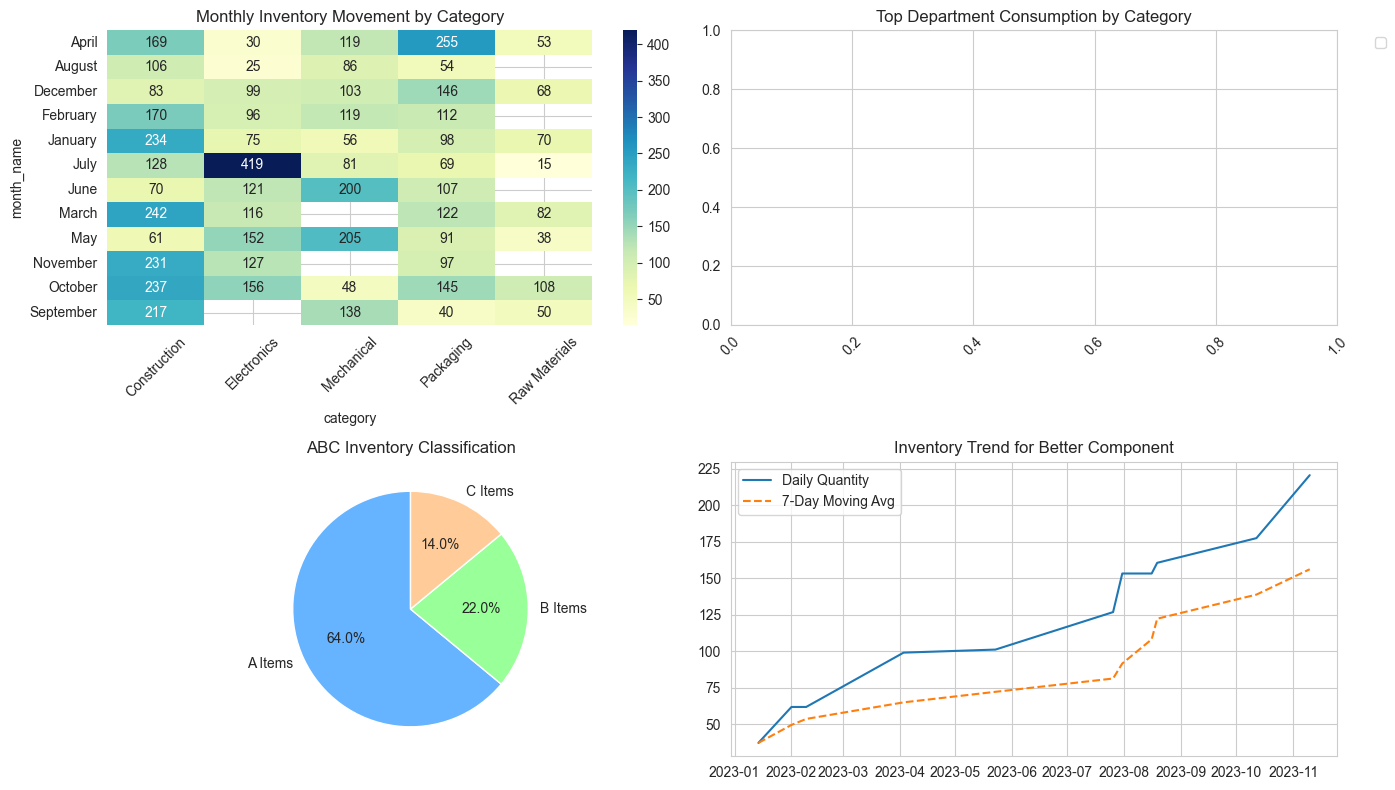

In [33]:
def generate_visualizations():
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Get data
    results = execute_rolap_analysis()
    cuboids = create_and_analyze_cuboids()
    mining_results = perform_data_mining()
    
    # Set style
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 8))
    
    # 1. Inventory Movement Heatmap
    plt.subplot(2, 2, 1)
    heatmap_data = results['inventory_movement'].groupby(['month_name', 'category'])['total_quantity'].sum().unstack()
    sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".0f")
    plt.title("Monthly Inventory Movement by Category")
    plt.xticks(rotation=45)
    
    # 2. Department Consumption
    plt.subplot(2, 2, 2)
    sns.barplot(
        data=results['dept_consumption'].head(10),
        x='department_name',
        y='consumed_quantity',
        hue='category'
    )
    plt.title("Top Department Consumption by Category")
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 3. ABC Analysis Pie Chart
    plt.subplot(2, 2, 3)
    class_dist = mining_results['abc_analysis']['abc_class'].value_counts()
    class_dist.plot.pie(
        autopct='%1.1f%%',
        startangle=90,
        labels=['A Items', 'B Items', 'C Items'],
        colors=['#66b3ff','#99ff99','#ffcc99']
    )
    plt.title("ABC Inventory Classification")
    plt.ylabel("")
    
    # 4. Inventory Trend with Moving Average
    plt.subplot(2, 2, 4)
    sample_material = mining_results['inventory_trend']['material_name'].iloc[0]
    sample_data = mining_results['inventory_trend'][mining_results['inventory_trend']['material_name'] == sample_material]
    plt.plot(sample_data['date_id'], sample_data['quantity'], label='Daily Quantity')
    plt.plot(sample_data['date_id'], sample_data['7_day_ma'], label='7-Day Moving Avg', linestyle='--')
    plt.title(f"Inventory Trend for {sample_material}")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Generate visualizations
generate_visualizations()

In [34]:
def prepare_clustering_data():
    db = WarehouseDB()
    db.connect()
    
    try:
        # Get material features including:
        # - Inventory characteristics (quantity, min, max)
        # - Movement patterns (frequency, quantity)
        # - Department usage
        material_data = pd.read_sql("""
        WITH material_stats AS (
            SELECT 
                m.material_id,
                m.material_name,
                m.category,
                m.current_quantity,
                m.min_quantity,
                m.max_quantity,
                COUNT(f.transaction_id) as transaction_count,
                SUM(CASE WHEN f.quantity > 0 THEN f.quantity ELSE 0 END) as total_incoming,
                SUM(CASE WHEN f.quantity < 0 THEN ABS(f.quantity) ELSE 0 END) as total_outgoing,
                COUNT(DISTINCT dept.department_id) as departments_used_in
            FROM dim_material m
            LEFT JOIN fact_inventory f ON m.material_id = f.material_id
            LEFT JOIN dim_department dept ON f.department_id = dept.department_id
            GROUP BY m.material_id, m.material_name, m.category, 
                     m.current_quantity, m.min_quantity, m.max_quantity
        )
        SELECT 
            *,
            current_quantity/max_quantity as inventory_ratio,
            total_incoming/NULLIF(transaction_count, 0) as avg_incoming,
            total_outgoing/NULLIF(transaction_count, 0) as avg_outgoing,
            CASE 
                WHEN current_quantity < min_quantity THEN 1 ELSE 0 
            END as is_below_min
        FROM material_stats
        """, db.engine)
        
        return material_data.fillna(0)
        
    finally:
        db.close()

# Get the data
material_features = prepare_clustering_data()
print("Material features for clustering:")
display(material_features.head())

Successfully connected to database
Database connection closed
Material features for clustering:


,material_id,material_name,category,current_quantity,min_quantity,max_quantity,transaction_count,total_incoming,total_outgoing,departments_used_in,inventory_ratio,avg_incoming,avg_outgoing,is_below_min
0,WZ20230001,Staff Material,Construction,943.58,97.17,1056.15,5,154.28,5.49,2,0.893415,30.856000,1.098000,0
1,WZ20230002,East Part,Electronics,480.45,80.67,1180.32,15,226.28,204.95,1,0.407051,15.085333,13.663333,0
2,WZ20230003,Kitchen Part,Raw Materials,294.63,13.87,1488.57,6,30.67,127.18,1,0.197928,5.111667,21.196667,0
3,WZ20230004,Care Part,Construction,928.62,35.98,668.01,6,62.65,111.03,2,1.390129,10.441667,18.505000,0
4,WZ20230005,Better Component,Electronics,899.46,74.35,1211.53,11,166.83,106.38,4,0.742417,15.166364,9.670909,0


In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def preprocess_for_clustering(data):
    # Select numerical features for clustering
    features = data[[
        'current_quantity',
        'min_quantity',
        'max_quantity',
        'inventory_ratio',
        'transaction_count',
        'total_incoming',
        'total_outgoing',
        'avg_incoming',
        'avg_outgoing',
        'departments_used_in',
        'is_below_min'
    ]]
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Optional: Reduce dimensionality with PCA
    pca = PCA(n_components=0.95)  # Keep 95% of variance
    reduced_features = pca.fit_transform(scaled_features)
    
    return {
        'raw_features': features,
        'scaled_features': scaled_features,
        'pca_features': reduced_features,
        'scaler': scaler,
        'pca': pca
    }

# Preprocess the data
processed_data = preprocess_for_clustering(material_features)

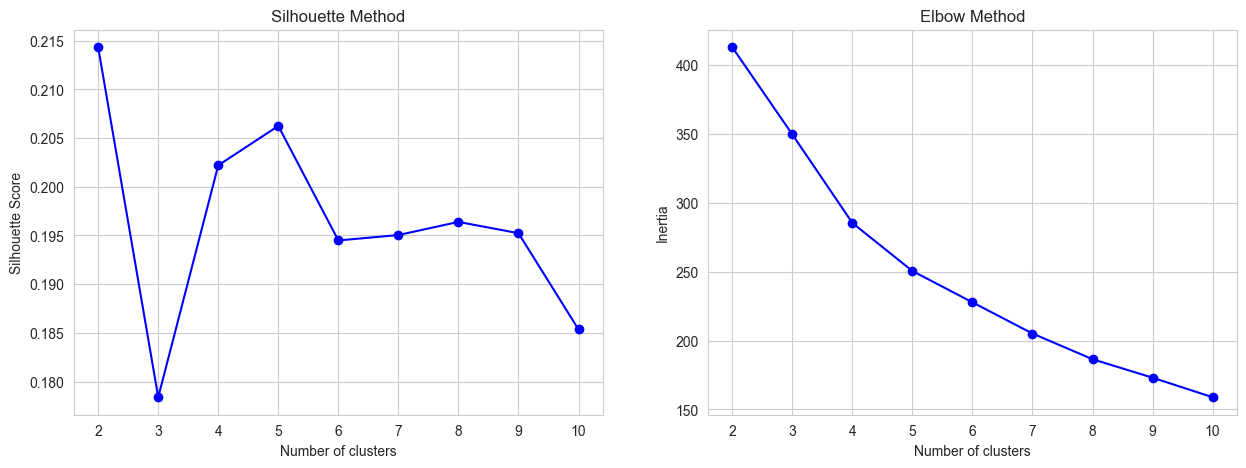

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def find_optimal_clusters(features, max_clusters=10):
    silhouette_scores = []
    inertia = []
    
    for n_clusters in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(features)
        
        # Calculate metrics
        silhouette_scores.append(silhouette_score(features, cluster_labels))
        inertia.append(kmeans.inertia_)
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(range(2, max_clusters+1), silhouette_scores, 'bo-')
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_title('Silhouette Method')
    
    ax2.plot(range(2, max_clusters+1), inertia, 'bo-')
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('Inertia')
    ax2.set_title('Elbow Method')
    
    plt.show()
    
    return silhouette_scores, inertia

# Find optimal clusters using PCA-reduced features
silhouette_scores, inertia = find_optimal_clusters(processed_data['pca_features'])

In [38]:
def apply_kmeans(features, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(features)
    return kmeans, clusters

# Apply clustering (using 4 clusters based on the elbow method)
n_clusters = 4  # Adjust based on your analysis
kmeans_model, cluster_labels = apply_kmeans(processed_data['pca_features'], n_clusters)

# Add cluster labels to our material data
material_features['cluster'] = cluster_labels

In [39]:
def analyze_clusters(material_data):
    # Group by cluster and calculate mean values
    cluster_profiles = material_data.groupby('cluster').mean(numeric_only=True)
    
    # Count items per cluster
    cluster_counts = material_data['cluster'].value_counts().sort_index()
    
    # Get most common categories in each cluster
    top_categories = material_data.groupby(['cluster', 'category']).size()\
        .groupby(level=0, group_keys=False).nlargest(3).unstack()
    
    return {
        'profiles': cluster_profiles,
        'counts': cluster_counts,
        'top_categories': top_categories
    }

# Analyze the clusters
cluster_analysis = analyze_clusters(material_features)

print("Cluster Profiles (Mean Values):")
display(cluster_analysis['profiles'])

print("\nNumber of Items per Cluster:")
display(cluster_analysis['counts'])

print("\nTop Categories in Each Cluster:")
display(cluster_analysis['top_categories'])

Cluster Profiles (Mean Values):


,current_quantity,min_quantity,max_quantity,transaction_count,total_incoming,total_outgoing,departments_used_in,inventory_ratio,avg_incoming,avg_outgoing,is_below_min
cluster,,,,,,,,,,,
0,560.352500,65.409375,1102.725000,8.000000,133.435000,60.540625,1.875000,0.543392,16.756792,7.422360,0.0
1,433.453571,34.657143,895.534286,8.428571,60.579286,164.178571,1.142857,0.595481,7.240221,19.683993,0.0
2,558.981176,58.827059,868.981765,13.117647,198.852941,168.815294,2.705882,0.951901,15.298499,12.757681,0.0
3,45.746667,63.423333,1559.036667,10.333333,81.590000,130.173333,2.333333,0.028778,7.649714,11.703476,1.0



Number of Items per Cluster:


cluster
0    16
1    14
2    17
3     3
Name: count, dtype: int64


Top Categories in Each Cluster:


category,Construction,Packaging,Electronics,Mechanical
cluster,,,,
0,7.0,5.0,3.0,NaN
1,6.0,2.0,4.0,NaN
2,3.0,NaN,4.0,4.0
3,NaN,1.0,1.0,1.0


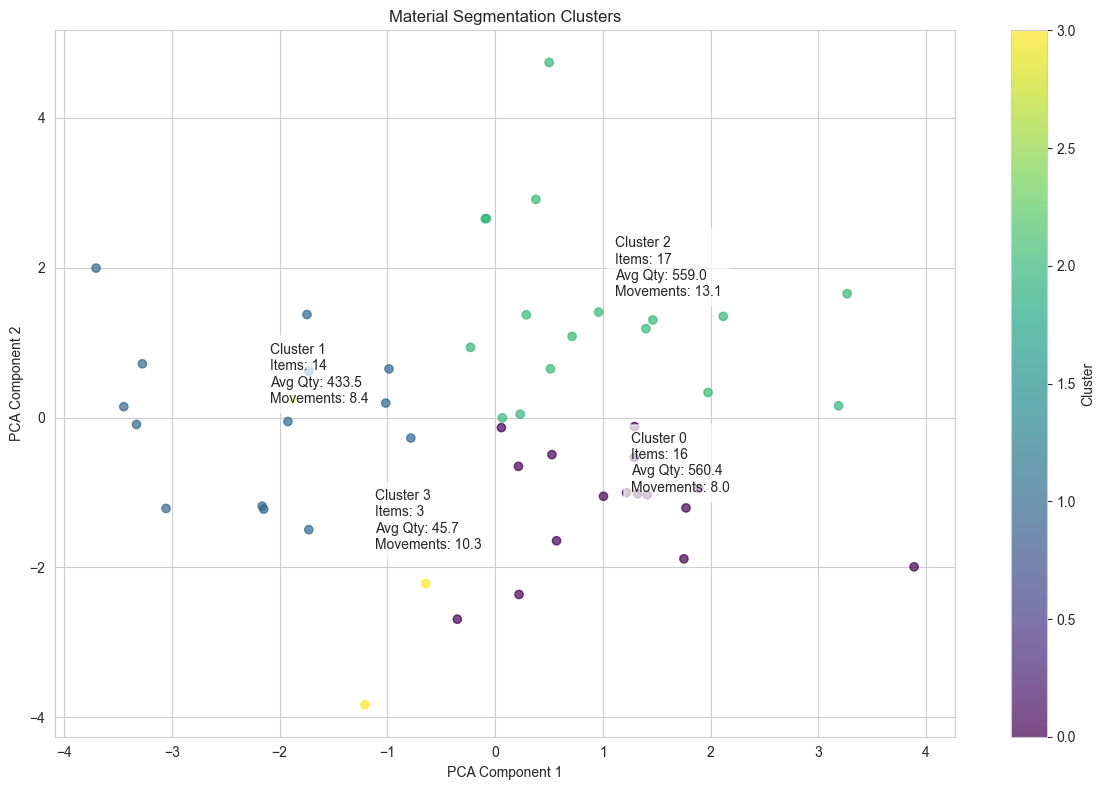

In [40]:
def visualize_clusters(material_data, pca_features):
    # Create a 2D visualization using the first two PCA components
    plt.figure(figsize=(12, 8))
    
    scatter = plt.scatter(
        pca_features[:, 0], 
        pca_features[:, 1], 
        c=material_data['cluster'], 
        cmap='viridis',
        alpha=0.7
    )
    
    plt.title('Material Segmentation Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter, label='Cluster')
    
    # Annotate with cluster characteristics
    for cluster in sorted(material_data['cluster'].unique()):
        cluster_data = material_data[material_data['cluster'] == cluster]
        centroid = cluster_data.mean(numeric_only=True)
        
        plt.annotate(
            f"Cluster {cluster}\n"
            f"Items: {len(cluster_data)}\n"
            f"Avg Qty: {centroid['current_quantity']:.1f}\n"
            f"Movements: {centroid['transaction_count']:.1f}",
            xy=(pca_features[material_data['cluster'] == cluster, 0].mean(),
                pca_features[material_data['cluster'] == cluster, 1].mean()),
            xytext=(10, 10),
            textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7)
        )
    
    plt.tight_layout()
    plt.show()

# Visualize the clusters
visualize_clusters(material_features, processed_data['pca_features'])

In [41]:
def save_clusters_to_db(material_data):
    db = WarehouseDB()
    db.connect()
    
    try:
        # Create a cluster mapping table if it doesn't exist
        db.execute("""
        CREATE TABLE IF NOT EXISTS material_clusters (
            material_id VARCHAR(25) PRIMARY KEY,
            cluster_id INT,
            FOREIGN KEY (material_id) REFERENCES dim_material(material_id)
        )
        """)
        
        # Prepare data for insertion
        cluster_data = [
            (row['material_id'], row['cluster']) 
            for _, row in material_data.iterrows()
        ]
        
        # Clear existing data
        db.execute("DELETE FROM material_clusters")
        
        # Insert new cluster assignments
        db.executemany("""
        INSERT INTO material_clusters (material_id, cluster_id)
        VALUES (%s, %s)
        """, cluster_data)
        
        print(f"Saved {len(cluster_data)} cluster assignments to database")
        return True
        
    except Exception as e:
        print(f"Error saving clusters: {e}")
        return False
    finally:
        db.close()

# Save to database
save_clusters_to_db(material_features)

Successfully connected to database
Saved 50 cluster assignments to database
Database connection closed


True

In [42]:

def cluster_based_analysis():
    db = WarehouseDB()
    db.connect()
    
    try:
        # 1. Cluster inventory status
        cluster_inventory = pd.read_sql("""
        SELECT 
            c.cluster_id,
            COUNT(*) as item_count,
            AVG(m.current_quantity) as avg_quantity,
            AVG(m.current_quantity/m.max_quantity) as avg_ratio,
            SUM(CASE WHEN m.current_quantity < m.min_quantity THEN 1 ELSE 0 END) as below_min_count
        FROM material_clusters c
        JOIN dim_material m ON c.material_id = m.material_id
        GROUP BY c.cluster_id
        ORDER BY c.cluster_id
        """, db.engine)
        
        # 2. Cluster movement patterns
        cluster_movement = pd.read_sql("""
        SELECT 
            c.cluster_id,
            t.transaction_type,
            COUNT(f.transaction_id) as transaction_count,
            SUM(ABS(f.quantity)) as total_quantity
        FROM fact_inventory f
        JOIN material_clusters c ON f.material_id = c.material_id
        JOIN dim_transaction_type t ON f.transaction_type_id = t.transaction_type_id
        GROUP BY c.cluster_id, t.transaction_type
        ORDER BY c.cluster_id, transaction_count DESC
        """, db.engine)
        
        # 3. Department usage by cluster
        dept_cluster_usage = pd.read_sql("""
        SELECT 
            d.department_name,
            c.cluster_id,
            COUNT(DISTINCT f.material_id) as unique_items,
            SUM(CASE WHEN f.quantity < 0 THEN ABS(f.quantity) ELSE 0 END) as quantity_used
        FROM fact_inventory f
        JOIN material_clusters c ON f.material_id = c.material_id
        JOIN dim_department d ON f.department_id = d.department_id
        GROUP BY d.department_name, c.cluster_id
        ORDER BY d.department_name, quantity_used DESC
        """, db.engine)
        
        return {
            'inventory_status': cluster_inventory,
            'movement_patterns': cluster_movement,
            'department_usage': dept_cluster_usage
        }
        
    finally:
        db.close()

# Run cluster-based analysis
cluster_analysis_results = cluster_based_analysis()

print("Cluster Inventory Status:")
display(cluster_analysis_results['inventory_status'])

print("\nCluster Movement Patterns:")
display(cluster_analysis_results['movement_patterns'])

print("\nDepartment Usage by Cluster:")
display(cluster_analysis_results['department_usage'].head(10))

Successfully connected to database
Database connection closed
Cluster Inventory Status:


,cluster_id,item_count,avg_quantity,avg_ratio,below_min_count
0,0,16,560.352500,0.543392,0.0
1,1,14,433.453571,0.595481,0.0
2,2,17,558.981176,0.951901,0.0
3,3,3,45.746667,0.028778,3.0



Cluster Movement Patterns:


,cluster_id,transaction_type,transaction_count,total_quantity
0,0,TRANSFER,45,1169.52
1,0,IN,37,965.44
2,0,OUT,28,600.42
3,0,SCRAP,18,368.23
4,1,OUT,46,1372.86
5,1,SCRAP,33,925.64
6,1,TRANSFER,21,395.57
7,1,IN,18,452.54
8,2,TRANSFER,63,1782.95
9,2,IN,57,1597.55



Department Usage by Cluster:


,department_name,cluster_id,unique_items,quantity_used
0,Logistics,0,11,0.0
1,Logistics,3,3,0.0
2,Logistics,2,7,0.0
3,Logistics,1,3,0.0
4,Maintenance,2,7,0.0
5,Maintenance,1,1,0.0
6,Maintenance,0,5,0.0
7,Maintenance,3,2,0.0
8,Production,1,3,0.0
9,Production,0,6,0.0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15172\1675670546.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15172\1675670546.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15172\1675670546.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15172\1675670546.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.

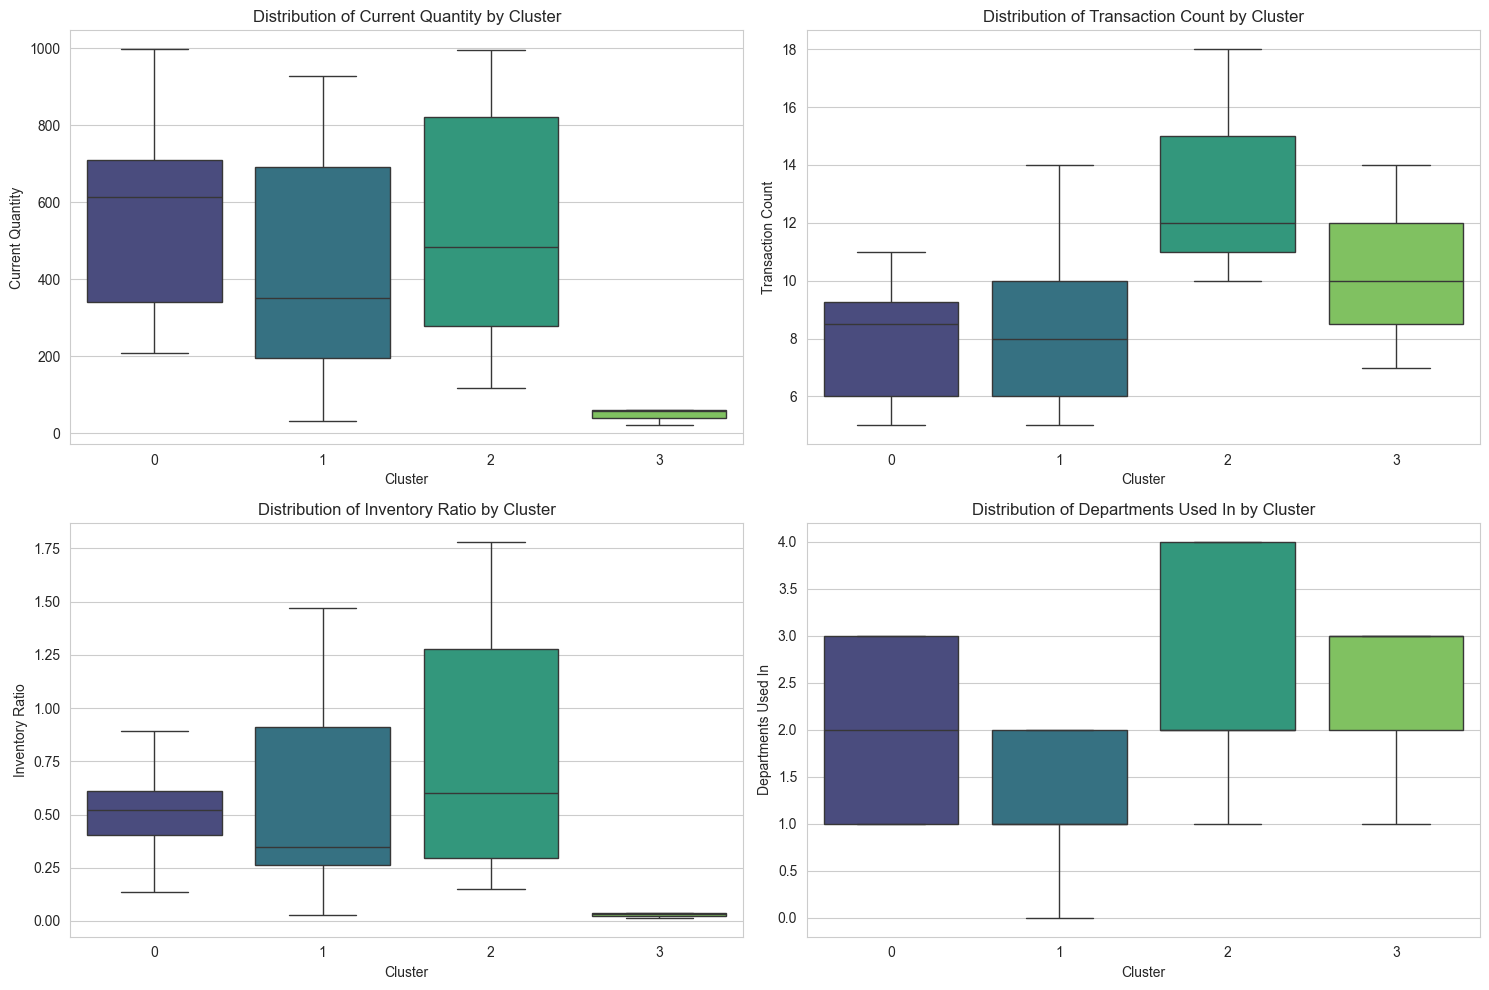

In [43]:
import seaborn as sns
def plot_cluster_characteristics(material_data):
    # Select key metrics to visualize
    metrics = [
        'current_quantity',
        'transaction_count',
        'inventory_ratio',
        'departments_used_in'
    ]
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        # Boxplot for each cluster
        sns.boxplot(
            x='cluster',
            y=metric,
            data=material_data,
            ax=axes[i],
            showfliers=False,
            palette='viridis'
        )
        axes[i].set_title(f'Distribution of {metric.replace("_", " ").title()} by Cluster')
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel(metric.replace("_", " ").title())
    
    plt.tight_layout()
    plt.show()

# Plot cluster characteristics
plot_cluster_characteristics(material_features)

In [46]:
%%writefile warehouse_app5.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import mysql.connector
from sqlalchemy import create_engine
from datetime import datetime

# Database connection function
def get_db_connection():
    return mysql.connector.connect(
        host="localhost",
        user="root",
        password="",
        database="warehouse"
    )

# Create SQLAlchemy engine
engine = create_engine('mysql+mysqlconnector://root:@localhost/warehouse')

# Set page config
st.set_page_config(
    page_title="Warehouse Management System",
    page_icon="📦",
    layout="wide"
)

# =============================================
# ID Generation Functions
# =============================================

def generate_material_id():
    """Generate material ID using WZ + year + 4-digit sequence"""
    conn = get_db_connection()
    cursor = conn.cursor()
    
    try:
        cursor.execute("""
        SELECT CONCAT('WZ', DATE_FORMAT(NOW(), '%Y'), 
                     LPAD(IFNULL(MAX(SUBSTRING(id, 7, 4)), 0) + 1, 4, '0'))
        FROM material
        WHERE id LIKE CONCAT('WZ', DATE_FORMAT(NOW(), '%Y'), '%')
        """)
        new_id = cursor.fetchone()[0]
        return new_id or f"WZ{datetime.now().year}0001"
    except mysql.connector.Error as err:
        st.error(f"Error generating ID: {err}")
        return f"WZ{datetime.now().year}0001"
    finally:
        if conn.is_connected():
            cursor.close()
            conn.close()

def generate_department_id():
    """Generate department ID using DEPT + 3-digit sequence"""
    conn = get_db_connection()
    cursor = conn.cursor()
    
    try:
        cursor.execute("""
        SELECT CONCAT('DEPT', LPAD(IFNULL(MAX(SUBSTRING(id, 5, 3)), 0) + 1, 3, '0'))
        FROM department
        WHERE id LIKE 'DEPT%'
        """)
        new_id = cursor.fetchone()[0]
        return new_id or "DEPT001"
    except mysql.connector.Error as err:
        st.error(f"Error generating ID: {err}")
        return "DEPT001"
    finally:
        if conn.is_connected():
            cursor.close()
            conn.close()

def generate_user_id():
    """Generate user ID using USER + 4-digit sequence"""
    conn = get_db_connection()
    cursor = conn.cursor()
    
    try:
        cursor.execute("""
        SELECT CONCAT('USER', LPAD(IFNULL(MAX(SUBSTRING(user_id, 5, 4)), 0) + 1, 4, '0'))
        FROM user
        WHERE user_id LIKE 'USER%'
        """)
        new_id = cursor.fetchone()[0]
        return new_id or "USER0001"
    except mysql.connector.Error as err:
        st.error(f"Error generating ID: {err}")
        return "USER0001"
    finally:
        if conn.is_connected():
            cursor.close()
            conn.close()

def generate_po_number():
    """Generate PO number using PO + date + 4-digit sequence"""
    conn = get_db_connection()
    cursor = conn.cursor()
    today = datetime.now().strftime('%Y%m%d')
    
    try:
        cursor.execute(f"""
        SELECT CONCAT('PO{today}', LPAD(IFNULL(MAX(SUBSTRING(po_number, 11, 4)), 0) + 1, 4, '0'))
        FROM purchase_order
        WHERE po_number LIKE 'PO{today}%'
        """)
        new_id = cursor.fetchone()[0]
        return new_id or f"PO{today}0001"
    except mysql.connector.Error as err:
        st.error(f"Error generating ID: {err}")
        return f"PO{today}0001"
    finally:
        if conn.is_connected():
            cursor.close()
            conn.close()

def generate_transaction_id():
    """Generate transaction ID using TR + date + 5-digit sequence"""
    conn = get_db_connection()
    cursor = conn.cursor()
    today = datetime.now().strftime('%Y%m%d')
    
    try:
        cursor.execute(f"""
        SELECT CONCAT('TR{today}', LPAD(IFNULL(MAX(SUBSTRING(transaction_id, 11, 5)), 0) + 1, 5, '0'))
        FROM inventory_transaction
        WHERE transaction_id LIKE 'TR{today}%'
        """)
        new_id = cursor.fetchone()[0]
        return new_id or f"TR{today}00001"
    except mysql.connector.Error as err:
        st.error(f"Error generating ID: {err}")
        return f"TR{today}00001"
    finally:
        if conn.is_connected():
            cursor.close()
            conn.close()

# =============================================
# Data Entry Functions (Updated with Auto-Generated IDs)
# =============================================

def add_material():
    st.subheader("Add New Material")
    
    with st.form("material_form"):
        # Auto-generate material ID
        material_id = generate_material_id()
        st.markdown(f"**Material ID:** `{material_id}`")
        
        name = st.text_input("Material Name*", max_chars=100)
        description = st.text_area("Description")
        category = st.selectbox("Category*", [
            "Electronics", "Mechanical", "Construction", 
            "Packaging", "Raw Materials", "Tools",
            "Safety Equipment", "Office Supplies"
        ])
        unit = st.selectbox("Unit*", ["pieces", "kg", "liters", "boxes", "units", "pallets"])
        current_quantity = st.number_input("Current Quantity*", min_value=0.0, step=0.1, value=0.0)
        min_quantity = st.number_input("Minimum Quantity*", min_value=0.0, step=0.1)
        max_quantity = st.number_input("Maximum Quantity*", min_value=0.0, step=0.1)
        location = st.text_input("Location (e.g., A1)", max_chars=50)
        
        submitted = st.form_submit_button("Add Material")
        
        if submitted:
            if not all([name, category, unit]):
                st.error("Please fill all required fields (marked with *)")
            else:
                try:
                    conn = get_db_connection()
                    cursor = conn.cursor()
                    
                    cursor.execute("""
                    INSERT INTO material (id, name, description, category, unit, 
                                        current_quantity, min_quantity, max_quantity, location)
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
                    """, (material_id, name, description, category, unit, 
                          current_quantity, min_quantity, max_quantity, location))
                    
                    conn.commit()
                    st.success(f"Material {name} added successfully with ID: {material_id}")
                except mysql.connector.Error as err:
                    st.error(f"Error: {err}")
                finally:
                    if conn.is_connected():
                        cursor.close()
                        conn.close()

def add_department():
    st.subheader("Add New Department")
    
    with st.form("department_form"):
        # Auto-generate department ID
        dept_id = generate_department_id()
        st.markdown(f"**Department ID:** `{dept_id}`")
        
        name = st.text_input("Department Name*", max_chars=100)
        manager = st.text_input("Manager Name", max_chars=100)
        contact = st.text_input("Contact Information", max_chars=50)
        
        submitted = st.form_submit_button("Add Department")
        
        if submitted:
            if not name:
                st.error("Department name is required")
            else:
                try:
                    conn = get_db_connection()
                    cursor = conn.cursor()
                    
                    cursor.execute("""
                    INSERT INTO department (id, name, manager, contact)
                    VALUES (%s, %s, %s, %s)
                    """, (dept_id, name, manager, contact))
                    
                    conn.commit()
                    st.success(f"Department {name} added successfully with ID: {dept_id}")
                except mysql.connector.Error as err:
                    st.error(f"Error: {err}")
                finally:
                    if conn.is_connected():
                        cursor.close()
                        conn.close()

def add_user():
    st.subheader("Add New User")
    
    # Get departments for dropdown
    departments = pd.read_sql("SELECT id, name FROM department", engine)
    dept_options = {row['id']: row['name'] for _, row in departments.iterrows()}
    
    with st.form("user_form"):
        # Auto-generate user ID
        user_id = generate_user_id()
        st.markdown(f"**User ID:** `{user_id}`")
        
        username = st.text_input("Username*", max_chars=50)
        password = st.text_input("Password*", type="password", max_chars=100)
        name = st.text_input("Full Name*", max_chars=100)
        role = st.selectbox("Role*", [
            "Manager", "Supervisor", "Operator", 
            "Clerk", "Technician", "Analyst"
        ])
        department_id = st.selectbox("Department", options=list(dept_options.keys()), 
                                    format_func=lambda x: dept_options[x])
        
        submitted = st.form_submit_button("Add User")
        
        if submitted:
            if not all([username, password, name, role]):
                st.error("Please fill all required fields (marked with *)")
            else:
                try:
                    conn = get_db_connection()
                    cursor = conn.cursor()
                    
                    cursor.execute("""
                    INSERT INTO user (user_id, username, password, name, role, department_id)
                    VALUES (%s, %s, %s, %s, %s, %s)
                    """, (user_id, username, password, name, role, department_id))
                    
                    conn.commit()
                    st.success(f"User {name} added successfully with ID: {user_id}")
                except mysql.connector.Error as err:
                    st.error(f"Error: {err}")
                finally:
                    if conn.is_connected():
                        cursor.close()
                        conn.close()

def add_purchase_order():
    st.subheader("Add New Purchase Order")
    
    # Get materials and departments for dropdowns
    materials = pd.read_sql("SELECT id, name FROM material", engine)
    mat_options = {row['id']: row['name'] for _, row in materials.iterrows()}
    
    departments = pd.read_sql("SELECT id, name FROM department", engine)
    dept_options = {row['id']: row['name'] for _, row in departments.iterrows()}
    
    with st.form("po_form"):
        # Auto-generate PO number
        po_number = generate_po_number()
        st.markdown(f"**PO Number:** `{po_number}`")
        
        material_id = st.selectbox("Material*", options=list(mat_options.keys()), 
                                 format_func=lambda x: mat_options[x])
        quantity = st.number_input("Quantity*", min_value=0.01, step=0.01)
        order_date = st.date_input("Order Date*", value=datetime.now())
        expected_delivery = st.date_input("Expected Delivery Date*", value=datetime.now())
        status = st.selectbox("Status*", [
            "Draft", "Submitted", "Approved", "Received", "Cancelled"
        ])
        department_id = st.selectbox("Requesting Department*", 
                                   options=list(dept_options.keys()), 
                                   format_func=lambda x: dept_options[x])
        
        submitted = st.form_submit_button("Add Purchase Order")
        
        if submitted:
            if expected_delivery < order_date:
                st.error("Delivery date cannot be before order date")
            else:
                try:
                    conn = get_db_connection()
                    cursor = conn.cursor()
                    
                    cursor.execute("""
                    INSERT INTO purchase_order (po_number, material_id, quantity, 
                                              order_date, expected_delivery, status, department_id)
                    VALUES (%s, %s, %s, %s, %s, %s, %s)
                    """, (po_number, material_id, quantity, 
                          order_date, expected_delivery, status, department_id))
                    
                    conn.commit()
                    st.success(f"Purchase Order {po_number} added successfully!")
                except mysql.connector.Error as err:
                    st.error(f"Error: {err}")
                finally:
                    if conn.is_connected():
                        cursor.close()
                        conn.close()

def add_inventory_transaction():
    st.subheader("Add Inventory Transaction")
    
    # Get materials and users for dropdowns
    materials = pd.read_sql("SELECT id, name FROM material", engine)
    mat_options = {row['id']: row['name'] for _, row in materials.iterrows()}
    
    users = pd.read_sql("SELECT user_id, name FROM user", engine)
    user_options = {row['user_id']: row['name'] for _, row in users.iterrows()}
    
    # Get POs for reference (for IN transactions)
    purchase_orders = pd.read_sql("SELECT po_number FROM purchase_order", engine)
    po_options = purchase_orders['po_number'].tolist()
    
    with st.form("transaction_form"):
        # Auto-generate transaction ID
        transaction_id = generate_transaction_id()
        st.markdown(f"**Transaction ID:** `{transaction_id}`")
        
        material_id = st.selectbox("Material*", options=list(mat_options.keys()), 
                                 format_func=lambda x: mat_options[x])
        transaction_type = st.selectbox("Transaction Type*", 
                                      ["IN", "OUT", "TRANSFER", "SCRAP"])
        quantity = st.number_input("Quantity*", min_value=0.01, step=0.01)
        transaction_date = st.date_input("Transaction Date*", value=datetime.now())
        reference_number = st.selectbox("Reference PO (required for IN transactions)", 
                                      [""] + po_options) if transaction_type == "IN" else None
        user_id = st.selectbox("Performed By*", options=list(user_options.keys()), 
                             format_func=lambda x: user_options[x])
        notes = st.text_area("Notes")
        
        submitted = st.form_submit_button("Add Transaction")
        
        if submitted:
            if transaction_type == "IN" and not reference_number:
                st.error("Reference PO is required for IN transactions")
            else:
                try:
                    conn = get_db_connection()
                    cursor = conn.cursor()
                    
                    # Adjust quantity for OUT/SCRAP transactions
                    actual_quantity = -abs(quantity) if transaction_type in ["OUT", "SCRAP"] else quantity
                    
                    cursor.execute("""
                    INSERT INTO inventory_transaction (
                        transaction_id, material_id, transaction_type, 
                        quantity, transaction_date, reference_number, 
                        user_id, notes
                    )
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
                    """, (
                        transaction_id, material_id, transaction_type,
                        actual_quantity, transaction_date, reference_number if transaction_type == "IN" else None,
                        user_id, notes
                    ))
                    
                    # Update material quantity
                    if transaction_type == "IN":
                        cursor.execute("""
                        UPDATE material 
                        SET current_quantity = current_quantity + %s
                        WHERE id = %s
                        """, (quantity, material_id))
                    elif transaction_type in ["OUT", "SCRAP"]:
                        cursor.execute("""
                        UPDATE material 
                        SET current_quantity = current_quantity - %s
                        WHERE id = %s
                        """, (quantity, material_id))
                    
                    conn.commit()
                    st.success(f"Transaction {transaction_id} added successfully!")
                except mysql.connector.Error as err:
                    st.error(f"Error: {err}")
                finally:
                    if conn.is_connected():
                        cursor.close()
                        conn.close()

# =============================================
# Rest of your application (unchanged)
# =============================================

# Set page config and navigation (same as before)


# Sidebar for navigation
st.sidebar.title("Navigation")
page = st.sidebar.radio("Go to", [
    "Dashboard", 
    "Inventory Analysis", 
    "Material Clustering",
    "Transaction Explorer",
    "Data Entry"
])

# Page routing (same structure as before)
if page == "Data Entry":
    st.title("📝 Data Entry")
    entry_type = st.selectbox("Select Data Type to Add", [
        "Material",
        "Department",
        "User",
        "Purchase Order",
        "Inventory Transaction"
    ])
    
    if entry_type == "Material":
        add_material()
    elif entry_type == "Department":
        add_department()
    elif entry_type == "User":
        add_user()
    elif entry_type == "Purchase Order":
        add_purchase_order()
    elif entry_type == "Inventory Transaction":
        add_inventory_transaction()

# =============================================
# Rest of your existing pages (unchanged)
# =============================================

elif page == "Dashboard":
    st.title("📊 Warehouse Management Dashboard")
    
    # Key metrics
    col1, col2, col3 = st.columns(3)
    with col1:
        total_items = pd.read_sql("SELECT COUNT(*) FROM material", engine).iloc[0,0]
        st.metric("Total Materials", total_items)
    
    with col2:
        total_transactions = pd.read_sql("SELECT COUNT(*) FROM inventory_transaction", engine).iloc[0,0]
        st.metric("Total Transactions", total_transactions)
    
    with col3:
        low_stock = pd.read_sql(
            "SELECT COUNT(*) FROM material WHERE current_quantity < min_quantity", 
            engine
        ).iloc[0,0]
        st.metric("Low Stock Items", low_stock, delta_color="inverse")
    
    # Recent transactions
    st.subheader("Recent Inventory Movements")
    recent_transactions = pd.read_sql("""
    SELECT 
        t.transaction_id,
        m.name as material,
        t.transaction_type,
        t.quantity,
        t.transaction_date,
        d.name as department
    FROM inventory_transaction t
    JOIN material m ON t.material_id = m.id
    LEFT JOIN purchase_order po ON t.reference_number = po.po_number
    LEFT JOIN department d ON po.department_id = d.id
    ORDER BY t.transaction_date DESC
    LIMIT 10
    """, engine)
    st.dataframe(recent_transactions)
    
    # Inventory status pie chart
    st.subheader("Inventory Status")
    inventory_status = pd.read_sql("""
    SELECT 
        CASE 
            WHEN current_quantity < min_quantity THEN 'Below Minimum'
            WHEN current_quantity > max_quantity THEN 'Above Maximum'
            ELSE 'Within Range'
        END as status,
        COUNT(*) as count
    FROM material
    GROUP BY status
    """, engine)
    
    fig, ax = plt.subplots()
    ax.pie(
        inventory_status['count'],
        labels=inventory_status['status'],
        autopct='%1.1f%%',
        colors=['#ff9999','#66b3ff','#99ff99']
    )
    ax.axis('equal')
    st.pyplot(fig)


elif page == "Inventory Analysis":
    st.title("📈 Inventory Analysis")
    # Material selection
    materials = pd.read_sql("SELECT id, name FROM material", engine)
    selected_material = st.selectbox(
        "Select Material", 
        materials['name'],
        index=0
    )
    material_id = materials[materials['name'] == selected_material].iloc[0,0]
    
    # Get inventory history
    inventory_history = pd.read_sql(f"""
    SELECT 
        DATE(transaction_date) as date,
        SUM(quantity) as daily_change,
        SUM(SUM(quantity)) OVER (ORDER BY DATE(transaction_date)) as running_quantity
    FROM inventory_transaction
    WHERE material_id = '{material_id}'
    GROUP BY DATE(transaction_date)
    ORDER BY date
    """, engine)
    
    # Plot inventory trend
    st.subheader(f"Inventory Trend for {selected_material}")
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(inventory_history['date'], inventory_history['running_quantity'], label='Inventory Level')
    
    # Add min/max lines if available
    min_max = pd.read_sql(f"""
    SELECT min_quantity, max_quantity FROM material WHERE id = '{material_id}'
    """, engine).iloc[0]
    
    ax.axhline(y=min_max['min_quantity'], color='r', linestyle='--', label='Minimum Quantity')
    ax.axhline(y=min_max['max_quantity'], color='g', linestyle='--', label='Maximum Quantity')
    
    ax.set_xlabel("Date")
    ax.set_ylabel("Quantity")
    ax.legend()
    ax.grid(True)
    st.pyplot(fig)
    
    # Show transactions for this material
    st.subheader(f"Transactions for {selected_material}")
    material_transactions = pd.read_sql(f"""
    SELECT 
        transaction_id,
        transaction_type,
        quantity,
        transaction_date,
        reference_number,
        notes
    FROM inventory_transaction
    WHERE material_id = '{material_id}'
    ORDER BY transaction_date DESC
    LIMIT 20
    """, engine)
    st.dataframe(material_transactions)

elif page == "Material Clustering":
    st.title("🧩 Material Clustering Analysis")
    # Explanation
    st.markdown("""
    This section performs K-means clustering on materials based on:
    - Inventory characteristics (quantity, min, max)
    - Movement patterns (frequency, quantity)
    - Department usage
    """)
    
    if st.button("Run Clustering Analysis"):
        with st.spinner("Performing clustering..."):
            # Get data
            material_data = pd.read_sql("""
            WITH material_stats AS (
                SELECT 
                    m.id as material_id,
                    m.name as material_name,
                    m.category,
                    m.current_quantity,
                    m.min_quantity,
                    m.max_quantity,
                    COUNT(t.transaction_id) as transaction_count,
                    SUM(CASE WHEN t.transaction_type = 'IN' THEN t.quantity ELSE 0 END) as total_incoming,
                    SUM(CASE WHEN t.transaction_type IN ('OUT', 'SCRAP') THEN ABS(t.quantity) ELSE 0 END) as total_outgoing,
                    COUNT(DISTINCT po.department_id) as departments_used_in
                FROM material m
                LEFT JOIN inventory_transaction t ON m.id = t.material_id
                LEFT JOIN purchase_order po ON t.reference_number = po.po_number
                GROUP BY m.id, m.name, m.category, m.current_quantity, m.min_quantity, m.max_quantity
            )
            SELECT 
                *,
                current_quantity/max_quantity as inventory_ratio,
                total_incoming/NULLIF(transaction_count, 0) as avg_incoming,
                total_outgoing/NULLIF(transaction_count, 0) as avg_outgoing,
                CASE WHEN current_quantity < min_quantity THEN 1 ELSE 0 END as is_below_min
            FROM material_stats
            """, engine).fillna(0)
            
            # Preprocess
            features = material_data[[
                'current_quantity',
                'min_quantity',
                'max_quantity',
                'inventory_ratio',
                'transaction_count',
                'total_incoming',
                'total_outgoing',
                'avg_incoming',
                'avg_outgoing',
                'departments_used_in',
                'is_below_min'
            ]]
            
            scaler = StandardScaler()
            scaled_features = scaler.fit_transform(features)
            
            # Cluster
            kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
            clusters = kmeans.fit_predict(scaled_features)
            material_data['cluster'] = clusters
            
            # Show results
            st.success("Clustering completed!")
            
            # Cluster profiles
            st.subheader("Cluster Profiles")
            cluster_profiles = material_data.groupby('cluster').mean(numeric_only=True)
            st.dataframe(cluster_profiles)
            
            # Visualization
            st.subheader("Cluster Visualization (PCA Reduced)")
            
            # Reduce dimensions for visualization
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            reduced_features = pca.fit_transform(scaled_features)
            
            fig, ax = plt.subplots(figsize=(10, 6))
            scatter = ax.scatter(
                reduced_features[:, 0], 
                reduced_features[:, 1], 
                c=material_data['cluster'], 
                cmap='viridis',
                alpha=0.7
            )
            
            ax.set_title("Material Clusters")
            ax.set_xlabel("PCA Component 1")
            ax.set_ylabel("PCA Component 2")
            plt.colorbar(scatter, label='Cluster')
            st.pyplot(fig)
            
            # Show materials in each cluster
            st.subheader("Materials by Cluster")
            selected_cluster = st.selectbox(
                "Select Cluster to View Materials",
                sorted(material_data['cluster'].unique())
            )
            
            cluster_materials = material_data[material_data['cluster'] == selected_cluster][[
                'material_name', 'category', 'current_quantity', 
                'min_quantity', 'max_quantity', 'transaction_count'
            ]]
            st.dataframe(cluster_materials)


elif page == "Transaction Explorer":
    st.title("🔍 Transaction Explorer")
# Date range selector
    min_date, max_date = pd.read_sql("""
    SELECT MIN(transaction_date), MAX(transaction_date) FROM inventory_transaction
    """, engine).iloc[0]
    
    col1, col2 = st.columns(2)
    with col1:
        start_date = st.date_input("Start Date", min_date)
    with col2:
        end_date = st.date_input("End Date", max_date)
    
    # Transaction type filter
    transaction_types = pd.read_sql("""
    SELECT DISTINCT transaction_type FROM inventory_transaction
    """, engine)['transaction_type'].tolist()
    selected_types = st.multiselect(
        "Transaction Types", 
        transaction_types,
        default=transaction_types
    )
    
    if st.button("Load Transactions"):
        query = f"""
        SELECT 
            t.transaction_id,
            m.name as material,
            t.transaction_type,
            t.quantity,
            t.transaction_date,
            d.name as department,
            t.notes
        FROM inventory_transaction t
        JOIN material m ON t.material_id = m.id
        LEFT JOIN purchase_order po ON t.reference_number = po.po_number
        LEFT JOIN department d ON po.department_id = d.id
        WHERE t.transaction_date BETWEEN '{start_date}' AND '{end_date}'
        AND t.transaction_type IN ({','.join([f"'{t}'" for t in selected_types])})
        ORDER BY t.transaction_date DESC
        """
        
        transactions = pd.read_sql(query, engine)
        st.dataframe(transactions)
        
        # Summary statistics
        st.subheader("Transaction Summary")
        col1, col2, col3 = st.columns(3)
        
        with col1:
            st.metric("Total Transactions", len(transactions))
        
        with col2:
            incoming = transactions[transactions['quantity'] > 0]['quantity'].sum()
            st.metric("Total Incoming", f"{incoming:.2f}")
        
        with col3:
            outgoing = transactions[transactions['quantity'] < 0]['quantity'].sum()
            st.metric("Total Outgoing", f"{outgoing:.2f}")
        
        # Time series plot
        st.subheader("Daily Transaction Volumes")
        daily_volumes = transactions.groupby(
            pd.to_datetime(transactions['transaction_date']).dt.date
        )['quantity'].agg(['count', 'sum']).reset_index()
        
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.bar(daily_volumes['transaction_date'], daily_volumes['count'])
        ax.set_xlabel("Date")
        ax.set_ylabel("Number of Transactions")
        ax.grid(True)
        st.pyplot(fig)



Writing warehouse_app5.py


In [48]:
import os
os.getcwd()

'c:\\Users\\Administrator\\Desktop'

In [51]:
!streamlit run "C:/Users/Administrator/Desktop/warehouse_app5.py"


^C
